# Guppy Program Optimization using `tket`

**Download this notebook - {nb-download}`Guppy-opt-example.ipynb`**

This notebook can be run with the following package versions

In [ ]:
!uv pip install \
    "pytket~=2.11.0" \
    "guppylang~=0.21.6" \
    "hugr~=0.14.4" \
    "tket~=0.12.14"

In this notebook tutorial we will show how to call pytket optimization passes on quantum programs written in [Guppy](https://docs.quantinuum.com/guppy/). Guppy programs compile to  [HUGR](https://github.com/Quantinuum/hugr) which is an intermediate representation for hybrid quantum programs.

As of `tket-py` version 0.12.13 `(tket>=0.12.13)` we can call any serializable pass from [pytket.passes](https://docs.quantinuum.com/tket/api-docs/passes.html) on Guppy programs. The `PytketHugrPass` interface allows the user to define a `Hugr` -> `Hugr` transformation with a pass from the pytket package.

The `tket=0.12.14` release contains some key bug fixes for the optimization of Gupp programs.  


In [1]:
from graphviz import Digraph

from guppylang import guppy
from guppylang.std.angles import pi
from guppylang.std.quantum import cx, h, qubit, t, rz

from hugr.hugr.base import Hugr
from hugr.hugr.render import DotRenderer, RenderConfig

from tket.passes import NormalizeGuppy, PytketHugrPass, PassResult
from pytket.passes import RemoveRedundancies, SquashRzPhasedX

## Getting started - Flattening the Guppy generated HUGR

Currently the Guppy compiler produces a number of compilation artifacts which its helpful to remove before thinking about optimizing the quantum gates in the program.

This HUGR cleanup can be done with the [NormalizeGuppy](https://quantinuum.github.io/tket2/generated/tket.passes.NormalizeGuppy#tket.passes.NormalizeGuppy) pass from `tket` which removes `MakeTuple` nodes and dead functions from the HUGR graph. This simplification may be built in to the Guppy compiler in the future.

As a first example lets define a simple Guppy function which we can compile to HUGR. 

In [2]:
@guppy
def pauli_zz_rotation(q0: qubit, q1: qubit) -> None:
    cx(q0, q1)
    t(q1)
    cx(q0, q1)


zz_hugr_graph: Hugr = pauli_zz_rotation.compile_function().modules[0]

We can now draw this HUGR graph using the [DotRenderer](https://quantinuum.github.io/hugr/generated/hugr.hugr.render.DotRenderer.html).

In [3]:
# Configure Hugr visualizer
my_renderer = DotRenderer(RenderConfig(display_node_id=True, display_metadata=False))


def draw(hugr: Hugr) -> Digraph:
    """Draw a Hugr graph with the DotRenderer."""
    return my_renderer.render(hugr)

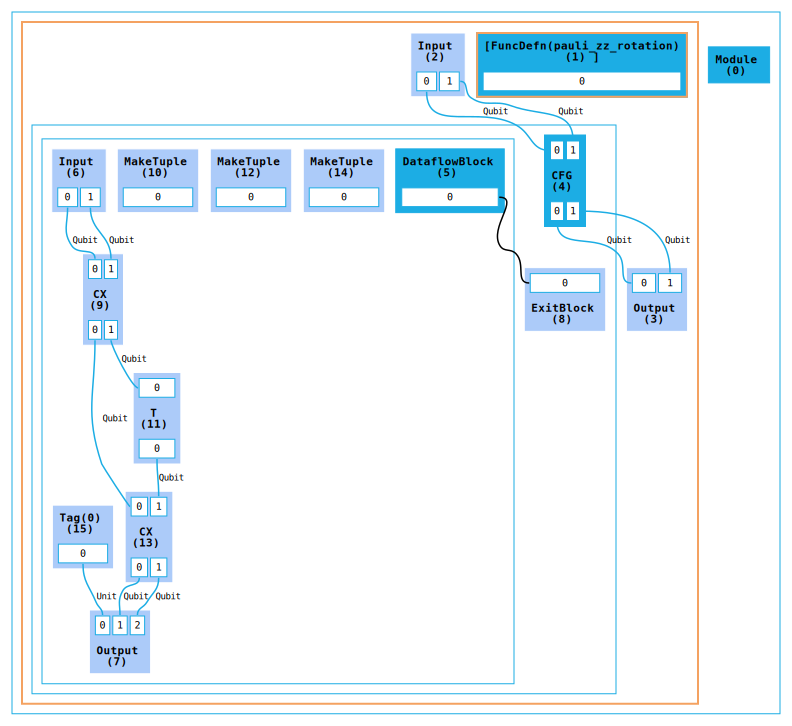

In [4]:
draw(zz_hugr_graph)

We can also print the data for each of the nodes of the graph.

In [5]:
for node, data in zz_hugr_graph.nodes():
    print(node, data)

Node(0) NodeData(op=Module(), parent=None, metadata={'name': '__main__', 'core.used_extensions': [{'name': 'tket.bool', 'version': '0.2.0'}, {'name': 'tket.debug', 'version': '0.2.0'}, {'name': 'tket.futures', 'version': '0.2.0'}, {'name': 'tket.global_phase', 'version': '0.1.0'}, {'name': 'tket.guppy', 'version': '0.2.0'}, {'name': 'tket.modifier', 'version': '0.1.0'}, {'name': 'tket.qsystem', 'version': '0.5.0'}, {'name': 'tket.qsystem.random', 'version': '0.2.1'}, {'name': 'tket.qsystem.utils', 'version': '0.3.0'}, {'name': 'tket.quantum', 'version': '0.2.1'}, {'name': 'tket.result', 'version': '0.2.0'}, {'name': 'tket.rotation', 'version': '0.2.0'}, {'name': 'tket.wasm', 'version': '0.4.1'}, {'name': 'guppylang', 'version': '0.1.0'}, {'name': 'prelude', 'version': '0.2.1'}, {'name': 'collections.array', 'version': '0.1.1'}, {'name': 'arithmetic.float', 'version': '0.1.0'}, {'name': 'arithmetic.float.types', 'version': '0.1.0'}, {'name': 'arithmetic.int', 'version': '0.1.0'}, {'name

In addtion, we can define a `count_ops` helper function to count the number of operations of a particular type.

We pass the string name of a particular `Op` as listed above and we can get the corresponding count for the number of instances in a graph.

In [6]:
def count_ops(hugr: Hugr, string_name: str) -> int:
    count = 0
    for _, data in hugr.nodes():
        if string_name in data.op.name():
            count += 1

    return count

In [7]:
print(f"Total number of HUGR nodes = {zz_hugr_graph.num_nodes()}")
print(f"# CX operations = {count_ops(zz_hugr_graph, 'CX')}")
print(f"# MakeTuple operations = {count_ops(zz_hugr_graph, 'MakeTuple')}")

Total number of HUGR nodes = 16
# CX operations = 2
# MakeTuple operations = 3


We can simplify the structure of our HUGR graph with the [NormalizeGuppy](https://quantinuum.github.io/tket2/generated/tket.passes.NormalizeGuppy#tket.passes.NormalizeGuppy) pass. This is recommded to "clear the way" for optimizations which reduce the number of quantum gates.

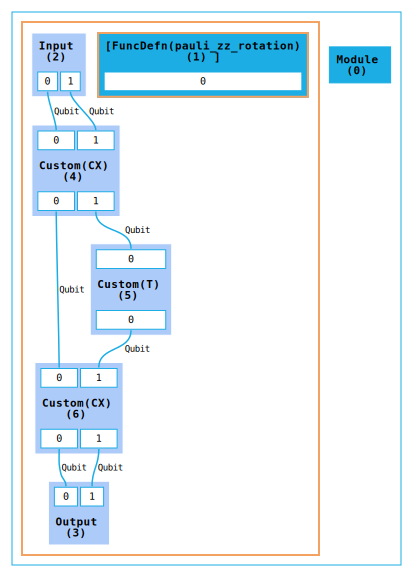

In [8]:
normalize = NormalizeGuppy()

cleaned_zz_hugr = normalize(
    zz_hugr_graph
)  # Invoke the NormalizeGuppy pass via the __call__ method.

draw(cleaned_zz_hugr)

In [9]:
print(f"Total number of HUGR nodes = {zz_hugr_graph.num_nodes()}")
print(f"# CX operations = {count_ops(zz_hugr_graph, 'CX')}")
print(f"# MakeTuple operations = {count_ops(zz_hugr_graph, 'MakeTuple')}")

Total number of HUGR nodes = 7
# CX operations = 2
# MakeTuple operations = 0


As you can see the normalization has simplified the structure of the HUGR whilst preserving the number of quantum gates.

## Example 1: Cancelling redundant CX gates 

Now let's consider some simple examples of optimizations that reduce the number of quantum gates.

Lets first define a Guppy function which has a pair of adjacent CX gates. These can be cancelled as the CX gate is self-inverse.

In [10]:
@guppy
def redundant_cx(q0: qubit, q1: qubit) -> None:
    h(q0)
    # Two adjacent CX gates with the same control and target can be cancelled.
    cx(q0, q1)
    cx(q0, q1)

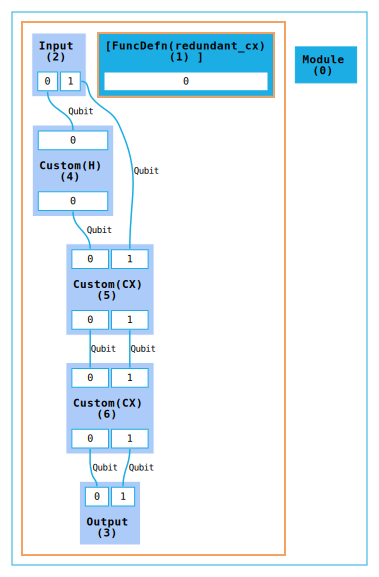

In [11]:
my_hugr_graph = normalize(
    redundant_cx.compile_function().modules[0]
)  # get normalized hugr for program above
draw(my_hugr_graph)

These CX gates can be cancelled using the `RemoveRedundancies` pass from pytket. To call this pass on a `Hugr` object we can create a [PytketHugrPass](https://quantinuum.github.io/tket2/generated/tket.passes.PytketHugrPass#tket.passes.PytketHugrPass) instance from the `pytket.passes` transformation.

In [12]:
rr_pass = PytketHugrPass(RemoveRedundancies())

pass_result: PassResult = rr_pass.run(my_hugr_graph)

Here we are using the `PytketHugrPass.run` method which returns a [PassResult](https://quantinuum.github.io/tket2/generated/tket.passes.PassResult#tket.passes.PassResult) object.

In [13]:
optimized_hugr = pass_result.hugr

In addition to the transformed `Hugr` instance, we can also see some more information from `PassResult`.

We can check whether our optimization was performed in place.

In [14]:
print(pass_result.inplace)

True


We can also check whether the `Hugr` was modified by the `PytketHugrPass` as follows.

In [15]:
print(pass_result.modified)

True


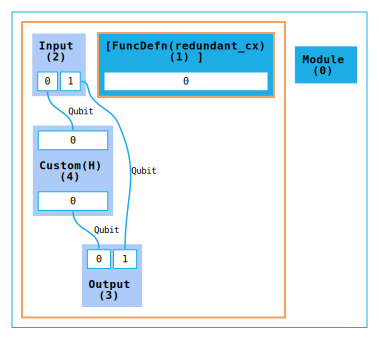

In [16]:
draw(optimized_hugr)

In [17]:
print(f"# CX gates = {count_ops(my_hugr_graph, 'CX')}")

# CX gates = 0


We see how both CX gates have been cancelled from our program.

## Example 2: Simplifying sequences of single qubit gates


The second example we will show is simplifying sequences of single qubit gates using the [SqaushRzPhasedX](https://docs.quantinuum.com/tket/api-docs/passes.html#pytket.passes.SquashRzPhasedX) pass from pytket. 

In [18]:
@guppy
def redundant_1q_gates(q0: qubit) -> None:
    rz(q0, pi / 2)
    rz(q0, pi / 2)
    rz(q0, pi / 2)


normalize2 = NormalizeGuppy(constant_folding=True)

my_1q_hugr_graph = normalize2(
    redundant_1q_gates.compile_function().modules[0]
)  # get normalized hugr for program above

As before, we can create a `Hugr` -> `Hugr` transformation with the `PytketHugrPass` interface.

In [19]:
squash_pass = PytketHugrPass(SquashRzPhasedX())

optimized_1q_hugr = squash_pass(my_1q_hugr_graph)

We should see that our optimisation has reduced the number of Rz rotations from 3 to 1 by combining the rotation angles.

In [20]:
print(f"#Rz gates in optimized program = {count_ops(optimized_1q_hugr, 'Rz')}")

#Rz gates in optimized program = 1
